In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import mlflow
import mlflow.sklearn
import mlflow.pyfunc
import mlflow.pyfunc.model
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import forestci as fci
import os
import warnings

Failed to import duecredit due to No module named 'duecredit'


In [2]:
# To ignore all warnings so no personal data gets leaked
warnings.filterwarnings("ignore")

In [3]:
notebook_path = os.path.abspath("6. Final_Modell.ipynb")
notebook_directory = os.path.dirname(notebook_path)

replacement_string = "models\\Tracking"
index = notebook_directory.find("\\notebooks")
modified_path = notebook_directory[:index]

modified_path += "\\" + replacement_string
tracking_uri = "file:///" + modified_path 

In [15]:
tracking_uri

'file:///c:\\Users\\Max_G\\OneDrive\\IUBH\\5_Semester\\Model_Engeneering\\Public_Transport_Forecasting\\models\\Tracking'

In [4]:
mlflow.set_tracking_uri(tracking_uri)

# Specify the experiment name
experiment_name = "Random_Forest_Final_with_Models"

# Set the active experiment context (creates the experiment if it doesn't exist)
experiment = mlflow.set_experiment(experiment_name)

2023/10/18 13:40:13 INFO mlflow.tracking.fluent: Experiment with name 'Random_Forest_Final_with_Models' does not exist. Creating a new experiment.


In [5]:
notebook_path = os.path.abspath("4. Cross Validation.ipynb")
notebook_directory = os.path.dirname(notebook_path)

replacement_string = "data\\interim\\Cluster_Data_All_Month\\"
index = notebook_directory.find("\\notebooks")
modified_path = notebook_directory[:index]

modified_path += "\\" + replacement_string + "df_all_counts_grouped.csv"

In [6]:
df_all_data = pd.read_csv(modified_path)

In [7]:
df_all_data.Date = pd.to_datetime(df_all_data['Date'])
df_all_data.drop(columns='Unnamed: 0', inplace=True)

In [8]:
# dropping all count columns, to add the specifically again in to dictionary with only each label
columns_to_drop = [col for col in df_all_data.columns if col.startswith('Count_')]

current_df_dict = {}

for label in range(0,6,1):
    # Drop all columns named 'count_'
    current_df = df_all_data.drop(columns=columns_to_drop)
    current_df[f'Count_{label}'] = df_all_data[f'Count_{label}']
    # Differencing the first 24 hours
    for diff in range(1,25,1):
        current_df[f'Count_{label}{-diff}'] = current_df[f'Count_{label}'].diff(diff)
    # differencing up to a week back
    for diff in range(48,169,24):
        current_df[f'Count_{label}{-diff}'] = current_df[f'Count_{label}'].diff(diff)
    current_df.dropna(inplace=True)   
    current_df.reset_index(inplace=True)  
    current_df.drop(columns=['Date', 'index'], inplace=True)             
    current_df_dict[label] = current_df

In [9]:
def random_forest_all_data(data, label, testing_lenght, max_features, max_depth, min_samples_leaf): 

    # Create an MLflow experiment and start a run
    with mlflow.start_run(experiment_id=experiment.experiment_id, run_name=f"Random_Forest_{label}") as run:
        train_data = data[:-testing_lenght]
        test_data = data[-testing_lenght:]

    
        X_train = train_data.drop([f'Count_{label}'], axis=1)
        y_train = train_data[f'Count_{label}']

        X_test = test_data.drop([f'Count_{label}'], axis=1)
        y_test = test_data[f'Count_{label}']
        
        # Initialize and train the Random Forest model
        rf_model = RandomForestRegressor(
            n_estimators=100,  
            max_features=max_features, # 11
            max_depth=max_depth, # 20,
            min_samples_leaf= min_samples_leaf, # 1,
            random_state=42,  # Set a random seed for reproducibility
            n_jobs=-1  # Use all available CPU cores for parallel processing
        )
        
        rf_model.fit(X_train, y_train)

        # Make predictions
        y_pred_train = rf_model.predict(X_train)
        y_pred_test = rf_model.predict(X_test)

        # Calculate AIC and R-squared
        
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        train_size = data[:-testing_lenght][f'Count_{label}'].sum()/len(data[:-testing_lenght])
        test_size = data[-testing_lenght:][f'Count_{label}'].sum()/len(data[-testing_lenght:])

        # Log AIC and R-squared
        mlflow.log_metrics({
            "RMSE_Train" : rmse_train,
            "RMSE_Test" : rmse_test,
            "MAE_Train" : mae_train,
            "MAE_Test" : mae_test,  
            "MAE_Train_Percentage" : mae_train/train_size,
            "MAE_Test_Percentage" : mae_test/test_size
        })

        # Log model parameters
        mlflow.log_params({
            'label' : label,
            'test_size' : test_size,
            'train_size' : train_size,
            'min_samples_leaf' : min_samples_leaf,
            'max_features' : max_features,
            'max_depth' : max_depth
        })

        #Log the trained model
        mlflow.sklearn.log_model(rf_model, f"final_random_forest_{label}")

In [10]:
testing_lenght=48

for label in current_df_dict:
        data = current_df_dict[label]
        if label == 0:
            random_forest_all_data(data, label, testing_lenght, 15, 30, 1)
        elif label == 1:
            random_forest_all_data(data, label, testing_lenght, 15, 20, 2)
        elif label == 2:
            random_forest_all_data(data, label, testing_lenght, 11, 20, 1)
        elif label == 3:
            random_forest_all_data(data, label, testing_lenght, 14, 35, 1)
        elif label == 4:
            random_forest_all_data(data, label, testing_lenght, 15, 35, 1)
        elif label == 5:
            random_forest_all_data(data, label, testing_lenght, 15, 35, 2)

In [11]:
metric_df_forest_data = mlflow.search_runs(experiment_ids=experiment.experiment_id)

In [12]:
metric_df_forest_data 

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.MAE_Train,metrics.MAE_Train_Percentage,metrics.MAE_Test,metrics.RMSE_Train,...,params.min_samples_leaf,params.test_size,params.train_size,params.label,params.max_features,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type
0,5785477c916c4697a48e874aa1586c86,905503404134756615,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-10-18 11:40:32.453000+00:00,2023-10-18 11:40:36.112000+00:00,2.468919,0.023742,8.913847,3.745737,...,2,131.45833333333334,103.9880239520958,5,15,Random_Forest_5,"[{""run_id"": ""5785477c916c4697a48e874aa1586c86""...",c:\Users\Max_G\anaconda3\lib\site-packages\ipy...,Max_G,LOCAL
1,0ef04feb67044f579bdc07a53900ad8c,905503404134756615,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-10-18 11:40:28.595000+00:00,2023-10-18 11:40:32.441000+00:00,5.774089,0.015073,13.252917,8.509556,...,1,438.75,383.0682634730539,4,15,Random_Forest_4,"[{""run_id"": ""0ef04feb67044f579bdc07a53900ad8c""...",c:\Users\Max_G\anaconda3\lib\site-packages\ipy...,Max_G,LOCAL
2,17a86f6958fa4a75b7f464621083b713,905503404134756615,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-10-18 11:40:25.061000+00:00,2023-10-18 11:40:28.585000+00:00,0.739940,0.021381,3.201458,1.083951,...,1,48.583333333333336,34.60670658682635,3,14,Random_Forest_3,"[{""run_id"": ""17a86f6958fa4a75b7f464621083b713""...",c:\Users\Max_G\anaconda3\lib\site-packages\ipy...,Max_G,LOCAL
3,fe5567e8a3f7416b9ec336a216f76fe7,905503404134756615,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-10-18 11:40:21.721000+00:00,2023-10-18 11:40:25.052000+00:00,0.304238,0.028481,1.122944,0.412717,...,1,14.708333333333334,10.682155688622755,2,11,Random_Forest_2,"[{""run_id"": ""fe5567e8a3f7416b9ec336a216f76fe7""...",c:\Users\Max_G\anaconda3\lib\site-packages\ipy...,Max_G,LOCAL
4,27382fa413a24868a007f9a4785fa534,905503404134756615,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-10-18 11:40:18.135000+00:00,2023-10-18 11:40:21.712000+00:00,1.361819,0.021381,4.643737,2.057114,...,2,85.97916666666667,63.692455089820356,1,15,Random_Forest_1,"[{""run_id"": ""27382fa413a24868a007f9a4785fa534""...",c:\Users\Max_G\anaconda3\lib\site-packages\ipy...,Max_G,LOCAL
5,2b649e7023f442898e7f849174e3eba1,905503404134756615,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-10-18 11:40:13.510000+00:00,2023-10-18 11:40:18.121000+00:00,5.278908,0.011909,8.912917,7.352047,...,1,598.2916666666666,443.27329341317363,0,15,Random_Forest_0,"[{""run_id"": ""2b649e7023f442898e7f849174e3eba1""...",c:\Users\Max_G\anaconda3\lib\site-packages\ipy...,Max_G,LOCAL


In [13]:
experiment.experiment_id

'905503404134756615'

In [17]:
# loading random forest south manhattan

logged_model = 'runs:/2b649e7023f442898e7f849174e3eba1/final_random_forest_0'

# Load model as a PyFuncModel.
loaded_model_0 = mlflow.pyfunc.load_model(logged_model)

In [18]:
loaded_model_0 = mlflow.sklearn.load_model(logged_model)

In [19]:
df_prediction = current_df_dict[0].drop(columns=['Count_0'])

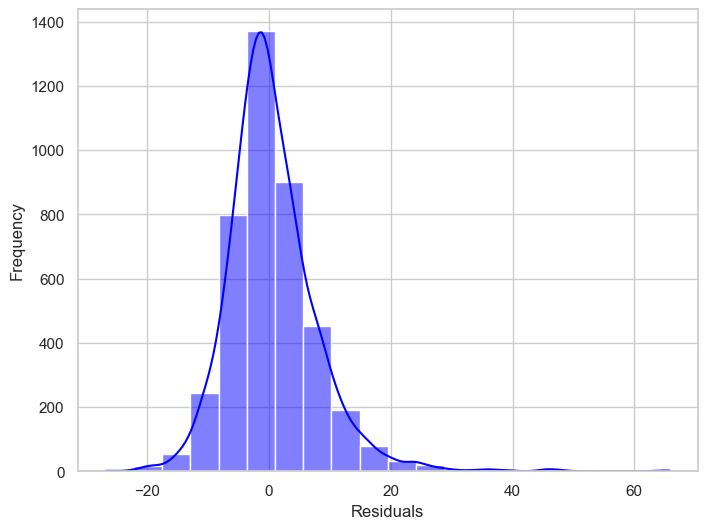

In [20]:
# Assuming you have residuals in current_df_dict[0]['Residuals']
residuals = current_df_dict[0]['Count_0'][:-48].values - loaded_model_0.predict(df_prediction[:-48])

# Set Seaborn style (optional)
sns.set(style="whitegrid")

# Create a histogram plot using Seaborn
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=20, kde=True, color='blue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [21]:
y_pred = loaded_model_0.predict(df_prediction[-48:])

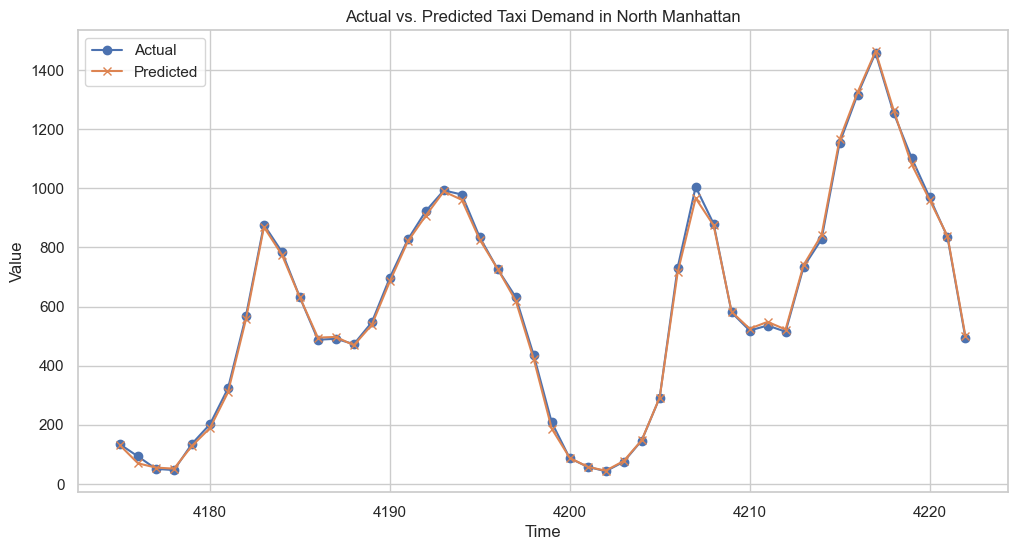

In [22]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_prediction[-48:].index, current_df_dict[0][-48:]['Count_0'], label='Actual', marker='o')
plt.plot(current_df_dict[0]['Count_0'][-48:].index, y_pred, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs. Predicted Taxi Demand in North Manhattan')
plt.grid(True)
plt.show()

# adding prediction intervalls

In [23]:
y_pred = loaded_model_0.predict(df_prediction[-48:])

In [24]:
V_IJ_unbiased = fci.random_forest_error(loaded_model_0, df_prediction[:-48].to_numpy(),
                                            df_prediction[-48:].to_numpy())

In [25]:
residuals_prediction = current_df_dict[0]['Count_0'][-48:].values - loaded_model_0.predict(df_prediction[-48:])

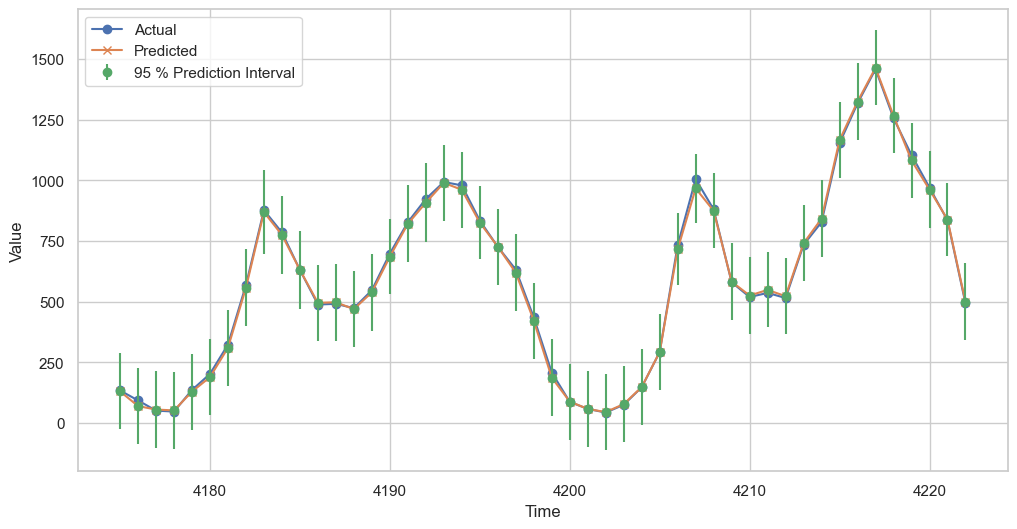

In [26]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_prediction[-48:].index, current_df_dict[0][-48:]['Count_0'], label='Actual', marker='o')
plt.plot(current_df_dict[0]['Count_0'][-48:].index, y_pred, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)

# Add a legend for 'Actual' and 'Predicted'
plt.legend(['Actual', 'Predicted'])

# Add error bars with a legend
plt.errorbar(current_df_dict[0][-48:]['Count_0'].index, y_pred, yerr=1.96*(np.sqrt(V_IJ_unbiased)+np.std(residuals_prediction)), fmt='o', label='95 % Prediction Interval')
plt.legend()

# plt.title('Actual vs. Predicted Taxi Demand in North Manhattan')
plt.show()
